# Explore - Natural Language Processing

In [46]:
import re
import nltk
import unicodedata
import pandas as pd


In [47]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

In [88]:
def clean(text):
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)\
                       .encode('ascii', 'ignore')\
                       .decode('utf-8', 'ignore')\
                       .lower())
    words = re.sub(r'[^\w\w+\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [89]:
df = pd.read_csv('../data/spam_clean.csv')

In [90]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [92]:
df.describe()

,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [93]:
labels = pd.concat([df.label.value_counts(),
                    df.label.value_counts(normalize=True)
                    ], axis=1)
labels.columns = ['n', 'percent']
labels

,n,percent
ham,4825,0.865937
spam,747,0.134063


In [94]:
ham_labels = clean(' '.join(df[df.label == 'ham'].text))
spam_labels = clean(' '.join(df[df.label == 'spam'].text))
all_words = clean(' '.join(df.text))


In [95]:
ham_freq = pd.Series(ham_labels).value_counts()
spam_freq = pd.Series(spam_labels).value_counts()
all_freq = pd.Series(all_words).value_counts()

spam_freq.head()

call    359
free    216
txt     150
ur      144
text    137
dtype: int64

In [96]:
word_counts = (pd.concat([ham_freq, spam_freq, all_freq], axis=1, sort=True)
                .set_axis(['ham', 'spam', 'all'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,ham,spam,all
+,11,18,29
+123,0,2,2
+447797706009,0,2,2
+449071512431,0,1,1
+a400,0,1,1


In [97]:
word_counts.sort_values(by='all', ascending=False).head(10)

,ham,spam,all
call,241,359,600
im,449,13,462
get,313,83,396
ur,240,144,384
go,273,31,304
4,168,119,287
dont,257,22,279
ok,272,5,277
free,59,216,275
know,241,26,267


In [98]:
pd.concat([word_counts[word_counts.spam == 0].sort_values(by='ham').tail(6),
           word_counts[word_counts.ham == 0].sort_values(by='spam').tail(6)])

,ham,spam,all
thats,94,0,94
i_,117,0,117
say,118,0,118
da,132,0,132
later,134,0,134
lor,160,0,160
a1000,0,35,35
awarded,0,38,38
guaranteed,0,50,50
tone,0,73,73


In [99]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


Text(0.5, 1.0, 'Proportion of Spam vs Ham for the 20 most common words')

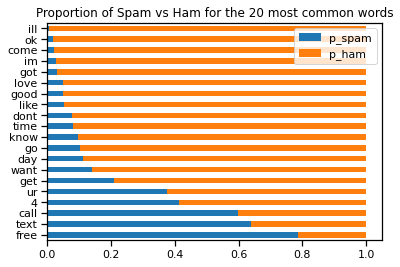

In [100]:
sns.set_context('notebook')
(word_counts
 .assign(p_spam=word_counts.spam / word_counts['all'],
         p_ham=word_counts.ham / word_counts['all'])
 .sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True))

plt.title('Proportion of Spam vs Ham for the 20 most common words')

In [101]:
(word_counts
 [(word_counts.spam > 10) & (word_counts.ham > 10)]
 .assign(ratio=lambda df: df.spam / (df.ham + .01))
 .sort_values(by='ratio')
 .pipe(lambda df: pd.concat([df.head(), df.tail()])))

,ham,spam,all,ratio
im,449,13,462,0.028953
good,223,12,235,0.053809
like,232,13,245,0.056032
need,171,11,182,0.064324
dont,257,22,279,0.085600
contact,14,56,70,3.997145
win,15,61,76,4.063957
cash,12,62,74,5.162365
mobile,15,135,150,8.994004
txt,13,150,163,11.529593


(-0.5, 399.5, 199.5, -0.5)

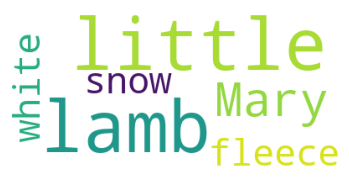

In [102]:
from wordcloud import WordCloud

sentence = 'Mary had a little lamb, little lamb, little lamb. Its fleece was white as snow.'

img = WordCloud(background_color='white').generate(sentence)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

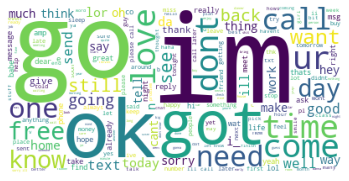

In [103]:
img = WordCloud(background_color='white').generate(' '.join(all_words))
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')

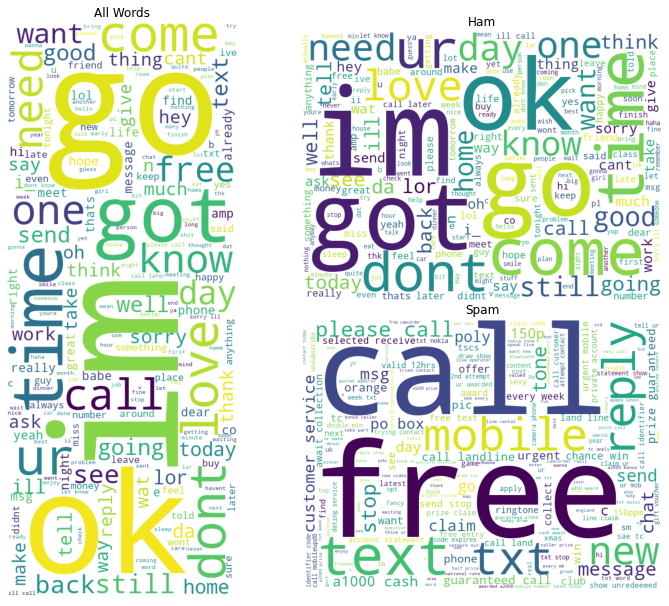

In [104]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
ham_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ham_labels))
spam_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(spam_labels))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(ham_cloud)
axs[2].imshow(spam_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Ham')
axs[2].set_title('Spam')

for ax in axs: ax.axis('off')


In [105]:
top_20_ham_bigrams = (pd.Series(nltk.ngrams(ham_labels, 2))
                      .value_counts()
                      .head(20))

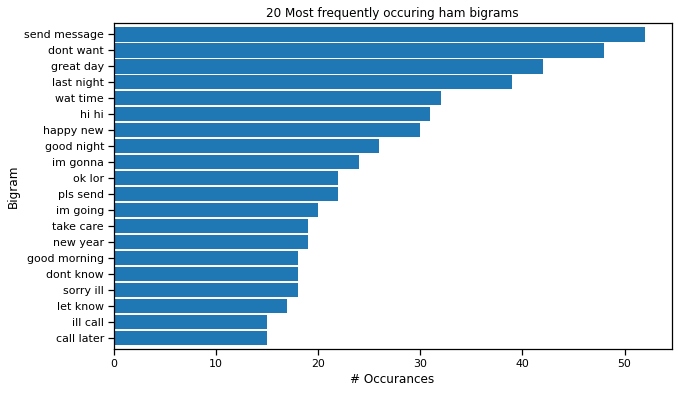

In [106]:
top_20_ham_bigrams.sort_values().plot.barh(width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ham bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ham_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

In [107]:
top_20_spam_bigrams = (pd.Series(nltk.ngrams(spam_labels, 2))
                        .value_counts()
                        .head(20))

In [108]:
top_20_spam_bigrams

(please, call)          44
(customer, service)     27
(po, box)               24
(a1000, cash)           23
(guaranteed, call)      23
(prize, guaranteed)     22
(send, stop)            19
(await, collection)     19
(selected, receive)     19
(every, week)           19
(chance, win)           19
(urgent, mobile)        18
(land, line)            18
(valid, 12hrs)          17
(claim, call)           17
(sae, tc)               16
(prize, claim)          16
(account, statement)    16
(call, 08000930705)     16
(call, customer)        15
dtype: int64

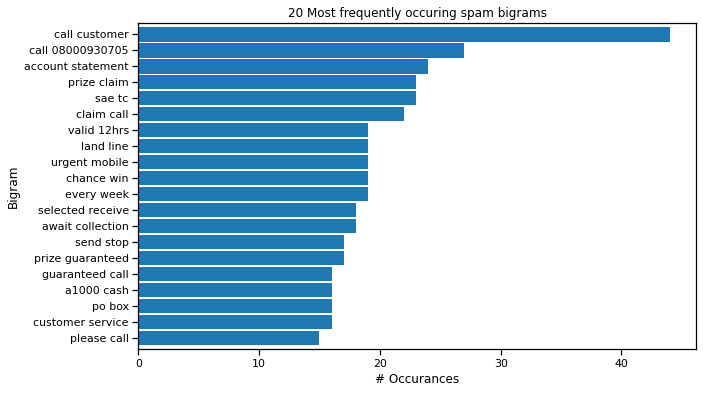

In [109]:
top_20_spam_bigrams.sort_values().plot.barh(width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring spam bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_spam_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)